In [1]:
import numpy as np
import pandas as pd

# cross validation purposes: create the cartesian product between the chosen values sets
from itertools import product 

import matplotlib.pyplot as plt
%matplotlib inline

#import os
#import seaborn

# Read Dataset

In [2]:
cmp = pd.read_csv("commViolUnnormData.txt", na_values='?')

In [3]:
# drop first non predictive features (communityname, state, countyCode, communityCode, "fold")
pred_features = cmp[cmp.columns[5:-18]]
regr_values = cmp[cmp.columns[-18:]]

In [4]:
# load in a dictionary the meanings of all the variables {variable_1:description_1, ...}
with open("variables_description.txt") as file:
    content = file.readlines()
    
variables_description = {}
for line in [c.strip() for c in content]:
    spl = line.split(':')
    variables_description[spl[0][3:]]=spl[1][1:]
    
#example
variables_description["PctHousOwnOcc"]

'percent of households owner occupied (numeric - decimal)'

# Drop features with a lot of missing values

In [5]:
print("Before dropping: {} features".format(str(pred_features.shape[1])))

#drop features that contain at least some threshold (from the total) of NaN values
cut_tresh = 0.75
to_drop = pred_features.columns[pred_features.count() < pred_features.shape[0]*cut_tresh]

pred_features = pred_features.drop(columns=to_drop)

print("After dropping: {} features".format(str(pred_features.shape[1])))

Before dropping: 124 features
After dropping: 102 features


# Imputing on features matrix

In [6]:
from collections import Counter

def value_withStrategy(v, strat):
    if strat == "mean":
        return np.mean(v)
    if strat == "median":
        return np.median(v)
    if strat == "most_frequent":
        return Counter(v).most_common(1)[0][0]
    print("Invalid imputing strategy!")
        
def imputing(df, strategy):
    # for each column that contain at least 1 NaN value...
    for nanCol in np.unique(np.where(pred_features.isna())[1]):
        nanRows = np.where(pred_features.iloc[:,nanCol].isna())[0] #find NaN rows for the current column
        available = df.iloc[~nanRows, nanCol]
        value = value_withStrategy(available, strategy) #compute the filling value
        df.iloc[nanRows, nanCol] = value

In [7]:
imputing(pred_features, "mean");

# Outliers Detection

-- TBD <br>
A thourough study from scratch of outliers detection is needed here, but for now it feels like it exceeds the course final project.

# Choose the Dependent Variable and drop possible missing values rows on it

In [8]:
print(regr_values.columns)

Index(['murders', 'murdPerPop', 'rapes', 'rapesPerPop', 'robberies',
       'robbPerPop', 'assaults', 'assaultPerPop', 'burglaries', 'burglPerPop',
       'larcenies', 'larcPerPop', 'autoTheft', 'autoTheftPerPop', 'arsons',
       'arsonsPerPop', 'ViolentCrimesPerPop', 'nonViolPerPop'],
      dtype='object')


In [9]:
regr_values.describe()

murders   murdPerPop        rapes  rapesPerPop     robberies  \
count  2215.000000  2215.000000  2007.000000   2007.00000   2214.000000   
mean      7.764786     5.859296    28.046338     36.25848    237.952123   
std      58.166468     9.156829   105.616135     34.23975   2250.720788   
min       0.000000     0.000000     0.000000      0.00000      0.000000   
25%       0.000000     0.000000     2.000000     11.53500      5.000000   
50%       1.000000     2.170000     7.000000     26.92000     19.000000   
75%       3.000000     8.365000    19.000000     51.47000     70.000000   
max    1946.000000    91.090000  2818.000000    401.35000  86001.000000   

        robbPerPop      assaults  assaultPerPop    burglaries   burglPerPop  \
count  2214.000000   2202.000000    2202.000000   2212.000000   2212.000000   
mean    162.612597    326.528156     378.004605    761.236890   1033.430203   
std     234.486624   1987.947941     438.238599   3111.702756    763.354442   
min       0.000000      0.000000       0.000000      2.000000     16.920000   
25%      27.647500     18.000000      94.187500     95.000000    511.690000   
50%      74.800000     56.000000     226.525000    205.000000    822.715000   
75%     187.155000    180.000000     504.387500    508.000000   1350.232500   
max    2264.130000  62778.000000    4932.500000  99207.000000  11881.020000   

           larcenies    larcPerPop      autoTheft  autoTheftPerPop  \
count    2212.000000   2212.000000    2212.000000      2212.000000   
mean     2137.629295   3372.979150     516.692586       473.965628   
std      7600.573464   1901.316145    3258.164244       504.666026   
min        10.000000     77.860000       1.000000         6.550000   
25%       392.000000   2040.080000      30.000000       156.952500   
50%       747.000000   3079.510000      75.000000       302.355000   
75%      1675.000000   4335.410000     232.500000       589.775000   
max    235132.000000  25910.550000  112464.000000      4968.590000   

            arsons  arsonsPerPop  ViolentCrimesPerPop  nonViolPerPop  
count  2124.000000   2124.000000          1994.000000    2118.000000  
mean     30.907721     32.153682           589.078922    4908.241804  
std     180.125248     39.240900           614.784518    2739.708901  
min       0.000000      0.000000             0.000000     116.790000  
25%       1.000000      7.670000           161.700000    2918.070000  
50%       5.000000     21.080000           374.060000    4425.450000  
75%      16.000000     42.852500           794.400000    6229.280000  
max    5119.000000    436.370000          4877.060000   27119.760000

In [10]:
def drop_naSample(df, vals):
    idxRow = np.where(vals.isna())[0]
    return df.drop(index=idxRow).values, vals.drop(index=idxRow).values.reshape(-1,1)

In [11]:
dep_var = "nonViolPerPop"
data,values = drop_naSample(pred_features, regr_values[dep_var])
variables_description[dep_var]

'total number of non-violent crimes per 100K popuation (numeric - decimal) potential GOAL attribute (to be predicted)'

# Exploratory Data Analysis

In [12]:
regr_values[dep_var].describe()

count     2118.000000
mean      4908.241804
std       2739.708901
min        116.790000
25%       2918.070000
50%       4425.450000
75%       6229.280000
max      27119.760000
Name: nonViolPerPop, dtype: float64

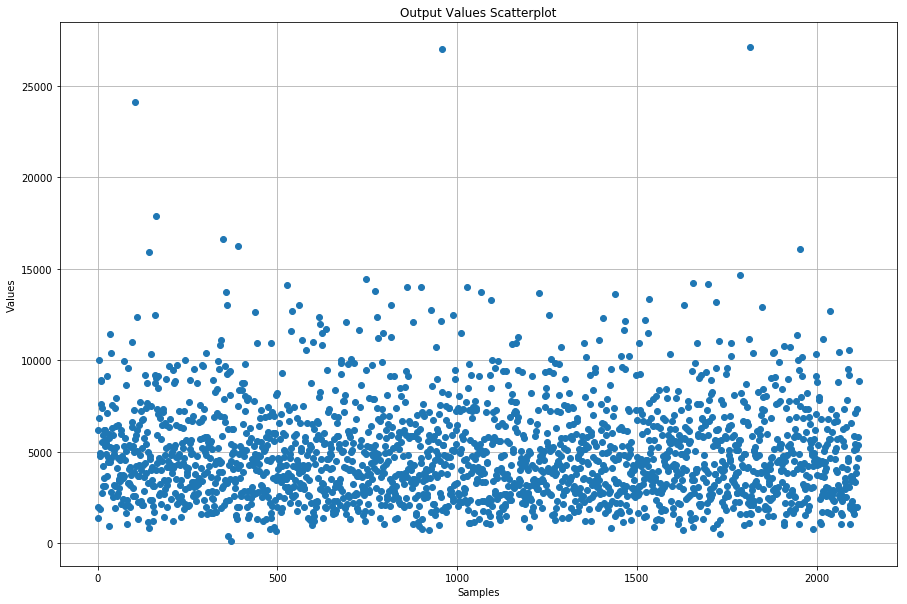

In [13]:
plt.figure(figsize=(15,10))
plt.plot(values, 'o')
plt.title("Output Values Scatterplot")
plt.xlabel("Samples")
plt.ylabel("Values")
plt.grid()

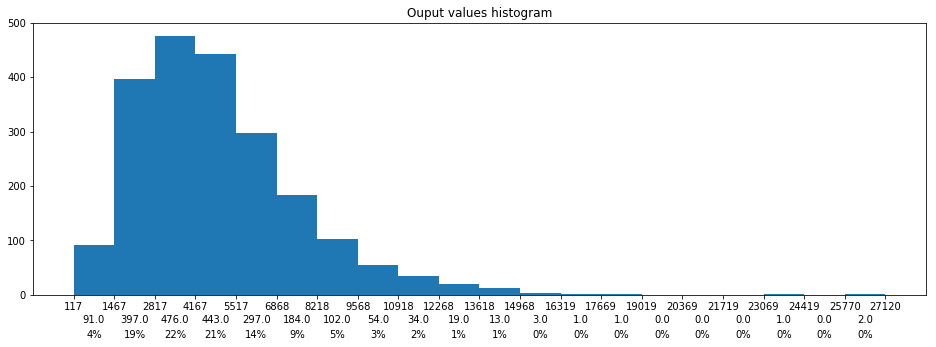

In [14]:
plt.figure(figsize=(16,5))
counts,bins,_ = plt.hist(values,bins=20)

bin_centers = 0.5 * np.diff(bins) + bins[:-1]
for count, x in zip(counts, bin_centers):
    # Label the raw counts
    plt.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -20), textcoords='offset points', va='top', ha='center')

    # Label the percentages
    percent = '%0.0f%%' % (100 * float(count) / counts.sum())
    plt.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -35), textcoords='offset points', va='top', ha='center')
    
plt.title("Ouput values histogram")
plt.xticks(bins)
plt.show()

In [15]:
def sample_pearsonCorrelation_withOutput(X, y):
    # r_x_y = cov(x,y)/(stdev(x)*stdev(y))
    _,d = X.shape
    corr = np.empty((d,1))
    
    y_centered = y-np.mean(y)
    y_stdev = np.std(y)
    
    for i in range(d):
        current = X[:,i]
        corr[i] = np.mean(np.multiply(current-np.mean(current), y_centered))/(np.std(current)*y_stdev)
        
    return corr

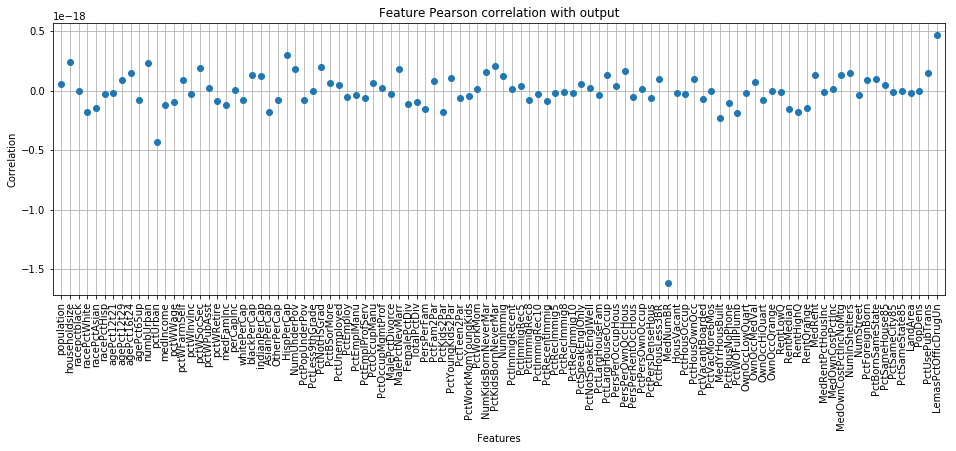

In [16]:
p_corr = sample_pearsonCorrelation_withOutput(data, values)

plt.figure(figsize=(16,5))
plt.plot(p_corr, "o")
plt.title("Feature Pearson correlation with output")
plt.xticks(range(len(pred_features.columns)), pred_features.columns, rotation=90)
plt.xlabel("Features")
plt.xlim(-1,102)
plt.ylabel("Correlation")
plt.grid()

In [25]:
d = data.shape[1]
plt.figure(figsize=(15,700))

labels = []
toRender_flags = []
for bin_idx in range(len(bins)-1):
    labels.append("{}<=v<{}".format(round(bins[bin_idx],0), round(bins[bin_idx+1],0)))
    toRender_flags.append((values>=bins[bin_idx]) & (values<bins[bin_idx+1]))
    
for var_idx in range(d):
    ax = plt.subplot(d,1,var_idx+1)
    plt.title("Feature #{}: \"{}\"".format(var_idx, pred_features.columns[var_idx]))
    plt.ylabel("Values")
    plt.grid()
    bPlots = []
    for flag in toRender_flags:
        bPlots.append(data[flag.flatten(),var_idx])
        # if there are some possible outliers or samples that span very widely,
        # the logaritmic scale might help visualise
        if np.var(data[flag.flatten(),var_idx])>1000:
            plt.yscale(value="log")
    plt.boxplot(bPlots)
    ax.set_xticks(range(1,len(labels)+1))
    ax.set_xticklabels(labels,rotation=-20)

plt.tight_layout()

/Users/danilo/.conda/envs/bcb/lib/python3.6/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


# Normalisation

In [ ]:
def normalise(matrix, strat):
    for j in range(matrix.shape[1]):
        mi = np.min(matrix[:,j])
        ma = np.max(matrix[:,j])
        di = ma-mi
        if (di > 1e-6):
            if strat=="0_mean,1_std":
                matrix[:,j] = (matrix[:,j]-np.mean(matrix[:,j]))/np.std(matrix[:,j])
            elif strat=="[0,1]":
                matrix[:,j] = (matrix[:,j]-mi)/di
            elif strat=="[-1,1]":
                matrix[:,j] = 2*((matrix[:,j]-mi)/di)-1
            else:
                print("Invalid normalisation strategy!")
        else:
            matrix[:,j] = 0

In [ ]:
strategy = "[-1,1]"
normalise(data,strategy)
normalise(values,strategy)

# Train-Test Split

In [ ]:
def trainTest_split(in_matrix, out_vect, train_amount=0.7):
    n,_ = in_matrix.shape

    trVl_Amount = int(n*train_amount) #training-validation amount
    indexes = np.random.permutation(n)
    idxTrVl = np.sort(indexes[0:trVl_Amount])
    idxTs = np.sort(indexes[trVl_Amount:])

    return in_matrix[idxTrVl], in_matrix[idxTs], out_vect[idxTrVl], out_vect[idxTs]

In [ ]:
trainVal_data, test_data, trainVal_values, test_values = trainTest_split(data, values, train_amount=0.7)

# Evaluation Metrics

In [ ]:
class Regression_evaluationMetric:
    def __init__(self, true, predicted):
        self.true = true.flatten()
        self.predicted = predicted.flatten()
        self.residuals = self.true-self.predicted
    
    def meanSquareError(self):
        return np.mean(np.square(self.residuals))
    
    def rootMeanSquareError(self):
        return np.sqrt(np.mean(np.square(self.residuals)))
    
    def meanAbsoluteError(self):
        return np.mean(np.abs(self.residuals))
    
    def rSquared(self):
        ss_residual = np.sum(np.square(self.residuals))
        ss_total = np.sum(np.square(self.true-np.mean(self.true)))        
        return 1 - ss_residual/ss_total
    
    def adjusted_rSquared(self, p):
        n = self.true.shape[0]
        return 1-(1-self.rSquared())*((n-1)/(n-p-1))


# Variable Selection - Models Definition

## 0. K-fold Cross Validation

In [ ]:
from itertools import product

def kFold_crossValidation_selectionGrid(k, parameters_dict, train_data, train_values, predictor, verbose=False):
    nVal,_ = train_data.shape
    
    # Validation indexes adjustment -------------------------------
    elemPerFold, remainder = np.divmod(nVal,k) #the remainder will be distributed across the firsts folds
    valIdxList = []
    start = 0

    # in each fold put as many samples as the division quotient +1 if the remainder is still positive
    # then decrease the division remainder by 1
    for i in range(k): 
        end = start+elemPerFold+int(remainder>0)
        valIdxList.append(np.arange(start,end)) 
        remainder -= 1
        start = end
    
    # Cross validation --------------------------------------------
    params_names = parameters_dict.keys()
    params_product = list(product(*parameters_dict.values())) # build all the hyp-par combination
    val_results = np.empty((len(valIdxList),len(params_product)))
    
    for row, valIdx in enumerate(valIdxList): # for each fold
        if verbose: print("#{} fold:".format(row+1))
        for col, params in enumerate(params_product):
            
            if verbose:
                update = col*100/len(params_product) # just print completion rate
                print("\t["+"#"*(int(update/5))+" "*(int((100-update)/5))+"] {}%".format(update))
                     
            arg_dict = {k:v for k,v in zip(params_names,params)} # {argument_name:argument_value, ... }
            
            
            predictor.fit(train_data[~valIdx], train_values[~valIdx], **arg_dict)
            pred = predictor.predict(train_data[valIdx])
            
            rem = Regression_evaluationMetric(trainVal_values[valIdx], pred)
            #val_results[row,col] = rem.rSquared()
            val_results[row,col] = rem.rootMeanSquareError()
            
    selected = np.argmin(val_results.mean(axis=0))
    return params_product[selected]

## 1. Matching Pursuit - Not Working (use the sklearn model)

### Project class definition

In [ ]:
class matchingPursuit:
    def __init__(self, iterations, weights = None, indexes = None):
        self.iterations = iterations
        self.weights = weights
        self.indexes = indexes
        
    def fit(self, data_matrix, output_vect):
        residual = output_vect.copy()
        self.weights = np.zeros((data_matrix.shape[1], 1))
        self.indexes = []

        #data_2norm = np.sqrt(np.sum(np.square(data_matrix), axis=0))
        data_2norm = np.linalg.norm(data_matrix, ord=2, axis=0).reshape(1,-1)

        for i in range(self.iterations):
            
            # project each column on the current residuals
            projection = np.matmul(residual.T, data_matrix)
            # find the most correlated variable: the one that in norm maximise the projections
            k = np.argmax(np.divide(np.square(projection), data_2norm))
            self.indexes.append(k)
            
            distance = projection[0,k]/np.linalg.norm(data_matrix[:,k], ord=2)
            self.weights[k,0] += distance # update the solution vector: canonical basis over the found column
            residual -= np.matmul(data_matrix, self.weights) # update the residual

        return self
    
    
    def predict(self, X):
        if self.weights is None:
            raise Exception("weights not initialised! need to first fit the model")
        return np.matmul(X, self.weights)
    
    
    def sort_featureImportances(self, columns=None, num=0):
        if self.weights is None:
            raise Exception("Need to first fit the model!")
            
        d = len(self.weights)
        n_printFeat = d if not num else num
        
        if columns is None:
            return sorted(zip(range(d),self.weights), key=lambda kv: abs(kv[1]), reverse=True)[:n_printFeat]

        if len(columns) != d:
            raise Exception("Argument list lenght differs from feature total amount")
        return sorted(zip(columns, self.weights), key=lambda kv: abs(kv[1]), reverse=True)[:n_printFeat]

In [ ]:
mp = matchingPursuit(iterations=20)
mp.fit(trainVal_data, trainVal_values)
mp.sort_featureImportances(columns=pred_features.columns)

In [ ]:
pred = mp.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

### SkLearn Class

In [ ]:
from sklearn.linear_model import orthogonal_mp
omp_coef = orthogonal_mp(trainVal_data, trainVal_values)
np.where(omp_coef)[0]

In [ ]:
pred = np.matmul(test_data, omp_coef)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

## 2. L1 Penalty (Lasso) with Proximal Gradient

### Project class definition

In [ ]:
class lasso_regression: # Iterative Soft Thresholding Algorithm
    def __init__(self, iterations, weights=None):
        self.iterations = iterations
        self.weights = weights
        
    def fit(self, data_matrix, output_vect, _lambda):
        n,d = data_matrix.shape
        self.weights = np.zeros((d,1))
        
        # convergence step-size: n/(2*||X^t*X||_2)
        step = n/(2*np.linalg.norm(np.matmul(data_matrix.T, data_matrix), ord=2))
        softTresh = step*_lambda

        for i in range(self.iterations):
            # gradient step of the mse formulation
            resid = np.matmul(data_matrix, self.weights) - output_vect
            grad_descent = (step/n)*np.matmul(data_matrix.T, resid)
            self.weights -= 2*grad_descent

            # proximal operator
            upper = self.weights > softTresh  # elem to be reduced
            lower = self.weights < -softTresh # elem to be increased
            self.weights[upper] -= softTresh
            self.weights[lower] += softTresh
            self.weights[~upper & ~lower] = 0

        return self
    
    def predict(self, X):
        if self.weights is None:
            raise Exception("weights not initialised! need to first fit the model")
        return np.matmul(X, self.weights)
    
    def sort_featureImportances(self, columns=None, num=0):
        if self.weights is None:
            raise Exception("Need to first fit the model!")
            
        d = len(self.weights)
        n_printFeat = d if not num else num
        
        if columns is None:
            return sorted(zip(range(d),self.weights), key=lambda kv: abs(kv[1]), reverse=True)[:n_printFeat]

        if len(columns) != d:
            raise Exception("Argument list lenght differs from feature total amount")
        return sorted(zip(columns, self.weights), key=lambda kv: abs(kv[1]), reverse=True)[:n_printFeat]

In [ ]:
k = 5
params_dict = {"_lambda":[0.0001,0.0005,0.001,0.01,0.1,1]}

lr = lasso_regression(iterations=1000)

win_regulariser = kFold_crossValidation_selectionGrid(k, params_dict, trainVal_data, trainVal_values, lr)[0]
print("Best regulariser: {}".format(win_regulariser))

lr.fit(trainVal_data, trainVal_values, win_regulariser)
#lr.sort_featureImportances(columns=pred_features.columns)
lr.sort_featureImportances()

In [ ]:
pred = lr.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))
print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

### SkLearn Class

In [ ]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.005)
lasso.fit(trainVal_data, trainVal_values)
np.where(lasso.coef_)[0]

In [ ]:
pred = lasso.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

## 3. Random Forest

### Project Decision Tree class definition

In [ ]:
class NumericalDecisionTree_regressor: # Least Square Regression Tree with either fixed parameter or pruning
    class Node:
        def __init__(self, isLeaf=False, feature=None, feature_importance=None, cut=None, average=None,
                     left=None, right=None):
            self.isLeaf = isLeaf
            self.feature = feature # if internal, on wich feature it executes the split
            self.feature_importance = feature_importance # solution variance reduction
            self.cut = cut # if internal, threahold value for the cut
            self.avg = average # mean of seen training values
            self.left = left
            self.right = right

        def print_tree(self):
            if self.left: self.left.print_tree()
            if self.cut:
                print("Feature: {}, cut: {}\n".format(self.feature, self.cut))
            else:
                print("Leaf => {}\n".format(self.avg))
            if self.right: self.right.print_tree()

        def print_tree_indented(self, level=0):
            if self.right: self.right.print_tree_indented(level+1)
            if self.cut:
                print("|    "*level+"{} => {}".format(self.feature, self.cut))
            else:
                print("|    "*level+"Leaf: {}".format(self.avg))                
            if self.left: self.left.print_tree_indented(level+1)
            
    def __init__(self, root=None, feature_importances=None):
        self.root = root
        self.feature_importances = feature_importances

        
    def fit(self, X, y, depth, minElems_perLeaf, post_pruning=False):
        
        self.feature_importances = {k:0 for k in range(X.shape[1])}
        
        if not post_pruning:
            self.root = self.learn(X, y.flatten(), depth, minElems_perLeaf)
        else:
            # train dataset, pruning dataset
            X_trn, X_val, y_trn, y_val = trainTest_split(X, y.flatten(), train_amount=0.7)
            self.root = self.learn(X_trn, y_trn, depth, minElems_perLeaf)
            self.prune(X_val, y_val)
        
        return self
        
    def learn(self, X, y, depth, minElems_perLeaf):
        n, d = X.shape

        if depth==0 or n<=minElems_perLeaf: # leaf # or fraction error of the root node??? 
            return self.Node(isLeaf=True, average=np.mean(y))
            
        best_costDescent = np.float("-inf") # split that maximise the error descent

        for i1 in range(d):
            sorted_idx = np.argsort(X[:,i1])
            sorted_x, sorted_y = X[sorted_idx, i1], y[sorted_idx]

            s_right, s_left = np.sum(sorted_y), 0
            n_right, n_left = n, 0

            for i2 in range(n-1):
                s_left += sorted_y[i2]
                s_right -= sorted_y[i2]
                n_left += 1
                n_right -= 1
                
                if sorted_x[i2]<sorted_x[i2+1]: # for a different value
                    # try to maximise this value: it is directly correlated 
                    # to the possible split information gain
                    new_costDescent = (s_left**2)/n_left + (s_right**2)/n_right
                    if new_costDescent > best_costDescent:
                        best_costDescent = new_costDescent
                        best_feature = i1
                        best_cut = (sorted_x[i2]+sorted_x[i2+1])/2
                        
        # update the importance for the selected feature
        feature_importance = np.var(y) - (np.sum(np.square(y))-best_costDescent)/n
        self.feature_importances[best_feature] += feature_importance

        left_idxs = X[:,best_feature] < best_cut
        
        return self.Node(feature=best_feature, feature_importance=feature_importance,
                         cut=best_cut, average=np.mean(y),
                         left = self.learn(X[left_idxs], y[left_idxs], depth-1, minElems_perLeaf),
                         right = self.learn(X[~left_idxs], y[~left_idxs], depth-1, minElems_perLeaf))
    
    def prune(self, X, y):
        # for statistics purposes check errors on different dataset portions and average them
        # in order to decide whether to prune or not (same code of k-fold cross-validation)
        n,_ = X.shape
        folds = 5
        elemPerFold, remainder = np.divmod(n, folds)
        foldsIdxsList = []
        start = 0
        for i in range(folds): 
            end = start+elemPerFold+int(remainder>0)
            foldsIdxsList.append(np.arange(start,end)) 
            remainder -= 1
            start = end
        
        # recursive: start checking if the root receive a possible positive pruning from its sons
        self.test_pruning(self.root, X, y, foldsIdxsList)
        return self
    
    def test_pruning(self, node, X, y, foldIdxs):
        if node.isLeaf: # leaf: start point of new possible pruning
            return True
        
        # check sons response: if one of them is negative to be pruned it means that it performs an important
        # predictive split
        if not self.test_pruning(node.left, X, y, foldIdxs) or not self.test_pruning(node.right, X, y, foldIdxs):
            return False
        
        # else proceed with testing the goodness of the current node split
        folds = len(foldIdxs)
        results = np.empty(folds)

        # not pruned errors on different folds
        for i, idxs in enumerate(foldIdxs):
            pred = self.predict(X[idxs])
            results[i] = Regression_evaluationMetric(true=y[idxs], predicted=pred).rootMeanSquareError()

        not_prunErr = np.mean(results)

        # pruned errors on different folds
        node.isLeaf = True
        for i, idxs in enumerate(foldIdxs):
            pred = self.predict(X[idxs])
            results[i] = Regression_evaluationMetric(true=y[idxs], predicted=pred).rootMeanSquareError()

        # if pruning improves the prediction RMSE then keep current node as leaf
        node.isLeaf = np.mean(results) <= not_prunErr
        
        if node.isLeaf:
            # lower feature importance computed during training phase
            self.feature_importances[node.feature] -= node.feature_importance 
            node.left = None
            node.right = None
            
        return node.isLeaf
            
    def predict(self, X):
        if self.root is None:
            raise Exception("Tree not initialised! need to first fit the model")

        n,_ = X.shape
        y = np.empty(n)
        
        for i in range(n):
            current = self.root
            while not current.isLeaf:
                if X[i,current.feature] < current.cut:
                    current = current.left
                else:
                    current = current.right
                
            y[i] = current.avg
        
        return y
                
    def pprint(self):
        self.root.print_tree_indented()
        
    def sort_featureImportances(self, columns=None, num=0):
        if self.feature_importances is None:
            raise Exception("Need to first fit the model!")
            
        d = len(self.feature_importances)
        n_printFeat = d if not num else num
        
        if columns is None:
            return sorted(self.feature_importances.items(), key=lambda kv: kv[1], reverse=True)[:n_printFeat]

        if len(columns) != d:
            raise Exception("Argument list lenght differs from feature total amount")
        return sorted(zip(columns, map(lambda kv: round(kv[1], 4), self.feature_importances.items())),
                      key=lambda kv: kv[1], reverse=True)[:n_printFeat]

#### with fixed depth and min elements per leaf (to be cross-validated)

In [ ]:
ndt = NumericalDecisionTree_regressor()
ndt.fit(trainVal_data, trainVal_values, depth=10, minElems_perLeaf=5)
ndt.pprint()

In [ ]:
#ndt.sort_featureImportances(columns=pred_features.columns)
ndt.sort_featureImportances()

In [ ]:
pred = ndt.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))
print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

#### with pruning

In [ ]:
ndt = NumericalDecisionTree_regressor()
ndt.fit(trainVal_data, trainVal_values, depth=200, minElems_perLeaf=10, post_pruning=True)
ndt.pprint()

In [ ]:
#ndt.sort_featureImportances(columns=pred_features.columns)
ndt.sort_featureImportances()

In [ ]:
pred = ndt.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

### Decision Tree SkLearn Class

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()
dtr.fit(trainVal_data, trainVal_values)
np.flip(np.argsort(dtr.feature_importances_))

In [ ]:
pred = dtr.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

### Project Random Forest class definition

In [ ]:
class NumericalRandomForest_regressor:
    def __init__(self, n_trees, trees=None, bootstrap_subSpace=None, outOfBag_error=None, feat_importances=None):
        self.n_trees = n_trees
        self.trees = trees
        self.bootSamplesIdxs_SubSp = bootstrap_subSpace
        self.oob_error = outOfBag_error
        self.feature_importances = feat_importances
        
    def fit(self, X, y, depth, minElems_perLeaf, post_pruning=True, verbose=False):
        n,d = X.shape
        
        self.trees = []
        self.bootSamplesIdxs_SubSp = []
        self.feature_importances = {k:0 for k in range(d)}
        
        n_learn = int(n/3) # Bootstrap amount to be taken aside
        # random subspace method amount
        d_learn = int(d/self.n_trees) if int(d/self.n_trees) >= int(np.sqrt(d)) else int(np.sqrt(d))
                
        # Fitting the forest -----------------------------------
        for i in range(self.n_trees):
            if verbose: print("\tFitting #{} tree".format(i+1))
            
            bootstrap_idxs = np.sort(np.random.permutation(n)[:n_learn])
            subspace_idxs = np.sort(np.random.permutation(d)[:d_learn])
            self.bootSamplesIdxs_SubSp.append((bootstrap_idxs, subspace_idxs))
                        
            dt = NumericalDecisionTree_regressor()
            
            self.trees.append(dt.fit(X[~bootstrap_idxs][:,subspace_idxs], y[~bootstrap_idxs],
                                     depth=depth, minElems_perLeaf=minElems_perLeaf, post_pruning=post_pruning))
            
            for k,v in dt.feature_importances.items():
                self.feature_importances[subspace_idxs[k]] += v
        
        # Out-Of-Bag Estimate for the forest -------------------
        oob_errors = []
        for sampleIdx in range(n):
            # finds all the tree that not have current sample in their bootstrapp set (not trained on it)
            # and the relative subspace on wich they have been trained
            missingTreesIdx_subspc = [(idx,subspace_idxs) for idx,(bootstrap_idxs,subspace_idxs)
                                      in enumerate(self.bootSamplesIdxs_SubSp)
                                      if sampleIdx not in bootstrap_idxs]

            if len(missingTreesIdx_subspc) == 0: continue
            
            regr_results = np.empty(len(missingTreesIdx_subspc)) # regression estimate of the selected trees
            for i, (missingTree_idx, tree_subSpace) in enumerate(missingTreesIdx_subspc):
                # reshape in order to correctly use the decision_tree.predict(...): it needs a matrix (num,dim)
                # while numpy matrix indexing returns (dim,)
                regr_results[i] = self.trees[missingTree_idx].predict(X[sampleIdx,tree_subSpace].reshape(1,-1))
            
            # done at this level of granularity because a sample might end up in 
            # being part of no bootstrap set of any tree (so we cannot predict wich value in y will be used)
            oob_errors.append(np.square(y[sampleIdx]-np.mean(regr_results)))
            #oob_errors.append(r2_score(np.mean(regr_results),y[sampleIdx]))
            #oob_errors.append(explained_variance_score(np.mean(regr_results),y[sampleIdx]))
            
        self.oob_error = np.sqrt(np.mean(oob_errors))
        return self
            
        
    def predict(self,X):
        if len(self.trees)==0:
            raise Exception("Trees not initialised! need to first fit the model")

        n,_ = X.shape
        results = np.empty((self.n_trees,n))
        for row, (tree,(_,subspace_idxs)) in enumerate(zip(self.trees, self.bootSamplesIdxs_SubSp)):
            results[row] = tree.predict(X[:,subspace_idxs])
            
        return np.mean(results,axis=0)
    
    def sort_featureImportances(self, columns=None, num=0):
        if self.feature_importances is None:
            raise Exception("Need to first fit the model!")
            
        d = len(self.feature_importances)
        n_printFeat = d if not num else num
        
        if columns is None:
            return sorted(self.feature_importances.items(), key=lambda kv: kv[1], reverse=True)[:n_printFeat]

        if len(columns) != d:
            raise Exception("Argument list lenght differs from feature total amount")
        return sorted(zip(columns, map(lambda kv: round(kv[1], 4), self.feature_importances.items())),
                      key=lambda kv: kv[1], reverse=True)[:n_printFeat]

#### try to find the optimal number of trees for the problem

In [ ]:
n_trees = [1,10,20,30,50,70,100,150,200]
oob_errors = np.empty(len(n_trees))

for i, num_t in enumerate(n_trees):
    print("Training {} tree".format(num_t)+'s'*(num_t!=1))
    nrf = NumericalRandomForest_regressor(num_t)
    # no train and test, cause it's a forest
    nrf.fit(data, values, depth=100, minElems_perLeaf=5);
    oob_errors[i] = nrf.oob_error

In [ ]:
plt.title("Out-Of-Bag errors per estimator amount (trees number)")
plt.errorbar(n_trees,oob_errors, fmt='--o');
plt.xticks(n_trees)
plt.grid()

### Random Forest SkLearn class

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100)
# oob error not working, need to perform evaluation on test split
rfr.fit(trainVal_data, trainVal_values.ravel())
np.flip(np.argsort(rfr.feature_importances_))

In [ ]:
pred = rfr.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))
print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

# Predictors - Models definition

## 1. Regularised Least Squares
   

In [ ]:
class tikhonov_leastSquares:
    def __init__(self, weights = None):
        self.weights = weights
        
    def fit(self, X, y, _lambda):
        inv = np.linalg.inv(np.matmul(X.T, X) + _lambda*np.eye(X.shape[1]))
        self.weights = np.matmul(inv, np.matmul(X.T, y))
        return self
    
    def predict(self, X):
        if self.weights is None:
            raise Exception("weights not initialised! need to first fit the model")
        return np.matmul(X, self.weights)

In [ ]:
k = 5
params_dict = {"_lambda":[1,1.3,1.5,1.7,2]}

tls = tikhonov_leastSquares()

win_regulariser = kFold_crossValidation_selectionGrid(k, params_dict, trainVal_data, trainVal_values, tls)[0]
print("Best regulariser: {}".format(win_regulariser))
tls.fit(trainVal_data, trainVal_values, win_regulariser)
pred = tls.predict(test_data)

rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

## 2. Random Forest

In [ ]:
rf = NumericalRandomForest_regressor(100)
rf.fit(trainVal_data, trainVal_values, depth=100, minElems_perLeaf=10);

pred = rf.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

In [ ]:
rf.oob_error

In [ ]:
rf.sort_featureImportances()

## 3. SVM - Not Working (use the sklearn model)

In [ ]:
class linear_SupportVector_regression:
    def __init__(self, weight=None, alpha=None, bias=None):
        self.x = alpha
        self.w = weight
        self.bias = bias
        self.Nabla = None
                
    def SMO2_ab(self, n, H, f, a, LB, UB, maxiter, eps, alpha_s):
        """
        % min_{x} .5 x H x + f' x 
        %         LB <= x <= UB
        %         a' x = b
        % n         grandezza problema length(x)
        % maxiter   max num it
        % eps       precisione
        % alpha_s   punto di inizio valido per x
        % Nabla     ....
        % err       flag di ok
        % x         valore della soluzione ottima
        % bias      ....
        """
        self.x = alpha_s
        self.Nabla = f
        for i in range(n):
            if (self.x[i] != 0.0):
                for j in range(n):
                    self.Nabla[j] += H[j,i] * self.x[i]
        iter_ = 0
        while True:
            minF_up = float("inf");
            maxF_low = float("-inf");
            for i in range(n): 
                F_i = self.Nabla[i]/a[i]
                if (LB[i] < self.x[i]) and (self.x[i] < UB[i]) :
                    if (minF_up > F_i):
                        minF_up = F_i
                        u = i
                    if (maxF_low < F_i):
                        maxF_low = F_i
                        v = i
                elif (((a[i] > 0) and (self.x[i] == LB[i])) or ((a[i] < 0) and (self.x[i] == UB[i]))) : 
                    if (minF_up > F_i):
                        minF_up = F_i
                        u = i
                elif (((a[i] > 0) and (self.x[i] == UB[i])) or ((a[i] < 0) and (self.x[i] == LB[i]))) : 
                    if (maxF_low < F_i):
                        maxF_low = F_i
                        v = i
            if ((maxF_low - minF_up) <= eps):
                err = 0.0
                break

            iter_ += 1
            if (iter_ >= maxiter):
                err = 1.0
                break

            if (a[u] > 0):
                tau_lb = (LB[u]-self.x[u])*a[u] 
                tau_ub = (UB[u]-self.x[u])*a[u] 
            else:
                tau_ub = (LB[u]-self.x[u])*a[u] 
                tau_lb = (UB[u]-self.x[u])*a[u]

            if (a[v] > 0):
                tau_lb = max(tau_lb,(self.x[v]-UB[v])*a[v]) 
                tau_ub = min(tau_ub,(self.x[v]-LB[v])*a[v]) 
            else:
                tau_lb = max(tau_lb,(self.x[v]-LB[v])*a[v]) 
                tau_ub = min(tau_ub,(self.x[v]-UB[v])*a[v])

            tau = (self.Nabla[v]/a[v]-self.Nabla[u]/a[u])/(H[u,u]/(a[u]*a[u])
                                                           +H[v,v]/(a[v]*a[v])
                                                           -2*H[v,u]/(a[u]*a[v]))
            tau = min(max(tau,tau_lb),tau_ub)
            self.x[u] += tau/a[u]
            self.x[v] -= tau/a[v]

            for i in range(n):
                self.Nabla[i] += H[u,i]*tau/a[u] - H[v,i]*tau/a[v]

        tsv = 0
        self.bias = 0.0

        for k in range(n):
            if ((self.x[k] > LB[k]) and (self.x[k] < UB[k])):
                self.bias -= self.Nabla[k]/a[k]
                tsv += 1

        if (tsv > 0):
            self.bias /= tsv
        else:    
            self.bias = -(maxF_low + minF_up)/2.0

        return err
    
    def fit(self, X, y, C):
        n = X.shape[0]
        cov = np.matmul(X, X.T)
        Q = np.matmul(np.matmul(np.diag(y.flatten()), cov),
                      np.diag(y.flatten()))
        
        if self.SMO2_ab(n,Q,-np.ones(n),y.flatten(),
                   np.zeros(n),C*np.ones(n),10000000,.0001,np.zeros(n)):
            print("Problem in SMO")
            
        self.w = np.matmul(np.matmul(X.T, np.diag(y.flatten())),
                           self.x)
        
        return self
    
    def predict(self, X):
        return np.matmul(X, self.w) + self.bias

In [ ]:
k = 5
params_dict = {"C":[0.00001,0.0001,0.001,0.01,0.1]}

lsvr = linear_SupportVector_regression()

win_regulariser = kFold_crossValidation_selectionGrid(k, params_dict, trainVal_data, trainVal_values, lsvr)[0]
print("Best regulariser: {}".format(win_regulariser))
lsvr.fit(trainVal_data, trainVal_values, C=win_regulariser)

pred = lsvr.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))
print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

In [ ]:
np.where(lsvr.x)

In [ ]:
from sklearn.svm import SVR
svr = SVR(kernel="linear", tol=.0001, C=1)
svr.fit(trainVal_data, trainVal_values.flatten());

In [ ]:
np.where(svr.dual_coef_)[1]

In [ ]:
pred = svr.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

# Recursive Features Elimination
<img src="img/Algo1.png">

In [ ]:
nrf = NumericalRandomForest_regressor(100)
nrf.fit(trainVal_data, trainVal_values, depth=200, minElems_perLeaf=5, verbose=False);

In [ ]:
print("Features sorted by their score:\n")
nrf.sort_featureImportances()

In [ ]:
print("Features sorted by their score:\n")
nrf.sort_featureImportances(columns=pred_features.columns)

In [ ]:
def rfe(estimator, parameters_dict, data, vals, n_features=None, verbose=False):
    _,d = data.shape
    nf = n_features if n_features else int(d/2)
    train_feat = list(range(d))    
    rmse = []
    r2 = []

    tr_data, ts_data, tr_vals, ts_vals = trainTest_split(in_matrix=data, out_vect=vals, train_amount=0.7)
    
    while d > nf:
        if verbose:
            update = round((data.shape[1]-d)*100/(data.shape[1]-nf), 2) # just print completion rate
            print("\t["+'#'*(int(update/5))+' '*(int((100-update)/5))+"] {}%".format(update))
            
        estimator.fit(X=tr_data[:,train_feat], y=tr_vals, **parameters_dict)
        pred = estimator.predict(ts_data)
        rem = Regression_evaluationMetric(ts_vals, pred)
        rmse.append(rem.rootMeanSquareError())
        r2.append(rem.rSquared())
            
        rank = estimator.sort_featureImportances()
        toDiscard_idx = rank[-1][0]
        train_feat.remove(train_feat[toDiscard_idx])

        d -= 1
    
    return (rmse, r2, train_feat)

In [ ]:
p_dict = {"depth":300, "minElems_perLeaf":5, "post_pruning":True, "verbose":False}
rootMSE, r2, surv_feature = rfe(NumericalRandomForest_regressor(100),
                                p_dict, trainVal_data, trainVal_values, verbose=True)

In [ ]:
plt.figure(figsize=(20,10))
x = range(trainVal_data.shape[1],len(surv_feature),-1)

plt.subplot(211)
plt.plot(x, rootMSE,"r", label="RMSE")
plt.xlim(trainVal_data.shape[1], len(surv_feature))
plt.xlabel("Number of Features")
plt.ylabel("Root Mean Square Error")
plt.legend()
plt.grid()

plt.subplot(212)
plt.plot(x, r2, label="R2")
plt.xlim(trainVal_data.shape[1], len(surv_feature))
plt.xlabel("Number of Features")
plt.ylabel("R Squared")
plt.legend()
plt.grid()

In [ ]:
pred_features.columns[surv_feature]

# Apply non linearity to the obtained results

In [ ]:
class kernel:        
    def gaussian(X, y=None, param=None):
        if param is None:
            param = 1/X.shape[1]
            
        if y is None:
            Q = np.exp(-param*np.square(pairwise_distances(X)))
        else:
            Q = np.exp(-param*np.square(pairwise_distances(X, y)))
        return Q

In [ ]:
class kernelTikhonov_leastSquares:
    def __init__(self, kernel_func, alphas=None):
        self.kernel_func = kernel_func
        self.alphas = alphas
        self.train_set = None
        
    def fit(self, X, y, _lambda, k_parameter):
        self.train_set = X
        
        Q = self.kernel_func(X, param=k_parameter)
        inv = np.linalg.inv(Q + _lambda*np.eye(X.shape[0]))
        self.alphas = np.matmul(inv, y)
        
        return self
    
    def predict(self, X):
        if self.alphas is None:
            raise Exception("weights not initialised! need to first fit the model")
        
        return np.matmul(self.kernel_func(X, self.train_set), self.alphas)

In [ ]:
k = 5
params_dict = {"_lambda":[0.5,1,1.3,1.5,1.7,2], "k_parameter":[0.0001,0.001, 0.01, 0.1, 1]}

ktls = kernelTikhonov_leastSquares(kernel_func=kernel.gaussian)

win_parameters = kFold_crossValidation_selectionGrid(k, params_dict, trainVal_data, trainVal_values, ktls)
print("Best regulariser: {}".format(win_parameters))
ktls.fit(trainVal_data, trainVal_values, _lambda=win_parameters[0], k_parameter=win_parameters[1])

pred = ktls.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))
print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

In [ ]:
pairwise_distances(trainVal_data)

In [ ]:
np.matmul(trainVal_data.T,trainVal_data)